In [3]:
# %load metamaps.py
"""Provides methods for loading/saving metamaps"""
import struct
from enum import IntEnum
from keras.utils import Sequence
import numpy as np
import os
import random

METAMAP_FILE_VERSION = 0x100

class TileType(IntEnum):
    """Tile types in a metamap"""
    UNREACHABLE = 0
    EMPTY = 1
    WALL = 2
    PUSHWALL = 3
    DOOR = 4


class EncodingDim(IntEnum):
    """Dimensions for the one-hot encoding of a metamap"""
    PLAYABLE = 0
    SOLID = 1
    PASSAGE = 2


class MetaMapsSequence(Sequence):
    """A sequence of real metamaps from a directory and randomly generated ones"""

    def __init__(self, maps_dir, batch_size):
        self.maps_dir = maps_dir
        self.batch_size = batch_size
        self.map_files = os.listdir(maps_dir)
        NUM_MAPS = len(self.map_files)
        real_maps = [(index, True) for index in range(NUM_MAPS)]
        fake_maps = [(index + NUM_MAPS, False) for index in range(NUM_MAPS)]
        map_order = real_maps + fake_maps
        np.random.shuffle(map_order)
        self.map_order = map_order

    def __len__(self):
        return int(len(self.map_order) / self.batch_size)

    def __getitem__(self, idx):
        map_batch = np.zeros((self.batch_size, 64, 64, len(EncodingDim)))
        label_batch = np.zeros((self.batch_size))

        for i in range(self.batch_size):
            (index, real_map) = self.map_order[idx * self.batch_size + i]
            if real_map:
                label_batch[i] = 1
                map_batch[i:] = load_metamap(
                    os.path.join(self.maps_dir, self.map_files[index]))
            else:
                map_batch[i:] = generate_random_map()

        return map_batch, label_batch


def generate_random_map():
    """Generate a random map"""
    width = 64
    height = 64
    size = width * height

    junk_map = np.zeros([size, len(EncodingDim)])

    for i in range(size):
        tile_type = random.randint(0, len(EncodingDim) - 1)
        junk_map[i, tile_type] = 1

    junk_map.shape = (width, height, len(EncodingDim))

    return junk_map


def load_all_metamaps(dirname):
    """Loads all the metamaps in the given directory, returning a giant numpy array"""
    map_names = os.listdir(dirname)
    all_maps = np.zeros((len(map_names), 64, 64, len(EncodingDim)))

    for index, map_name in enumerate(map_names):
        load_metamap_into(os.path.join(dirname, map_name), all_maps, index)

    return all_maps


def load_metamap_into(filename, all_maps, index):
    """Loads a metamap from a file into a numpy array of shape (width, height, 3)"""
    with open(filename, "rb") as fin:
        version = struct.unpack('Q', fin.read(8))[0]

        if version != METAMAP_FILE_VERSION:
            raise ValueError("Unsupported metamap version")

        width = struct.unpack('i', fin.read(4))[0]
        height = struct.unpack('i', fin.read(4))[0]

        raw_map = np.fromfile(fin, dtype=np.uint8)
        raw_map.shape = (width, height)

        for y in range(height):
            for x in range(width):
                tile_type = TileType(raw_map[y, x])
                if tile_type == TileType.EMPTY:
                    all_maps[index, y, x, EncodingDim.PLAYABLE] = 1
                elif tile_type == TileType.UNREACHABLE or tile_type == TileType.WALL:
                    all_maps[index, y, x, EncodingDim.SOLID] = 1
                elif tile_type == TileType.PUSHWALL or tile_type == TileType.DOOR:
                    all_maps[index, y, x, EncodingDim.PASSAGE] = 1


def load_metamap(filename):
    """Loads a metamap from a file into a numpy array of shape (width, height, 3)"""
    with open(filename, "rb") as fin:
        version = struct.unpack('Q', fin.read(8))[0]

        if version != METAMAP_FILE_VERSION:
            raise ValueError("Unsupported metamap version")

        width = struct.unpack('i', fin.read(4))[0]
        height = struct.unpack('i', fin.read(4))[0]
        size = width * height

        raw_map = np.fromfile(fin, dtype=np.uint8)
        one_hot = np.zeros([size, len(EncodingDim)])

        for i in range(size):
            tile_type = TileType(raw_map[i])
            if tile_type == TileType.EMPTY:
                one_hot[i, EncodingDim.PLAYABLE] = 1
            elif tile_type == TileType.UNREACHABLE or tile_type == TileType.WALL:
                one_hot[i, EncodingDim.SOLID] = 1
            elif tile_type == TileType.PUSHWALL or tile_type == TileType.DOOR:
                one_hot[i, EncodingDim.PASSAGE] = 1

        one_hot.shape = (width, height, len(EncodingDim))

        return one_hot


def save_metamap(metamap, filename):
    """Saves a metamap to a file"""
    with open(filename, "wb") as fout:
        fout.write(struct.pack('Q', METAMAP_FILE_VERSION))

        width = metamap.shape[0]
        height = metamap.shape[1]

        fout.write(struct.pack('i', width))
        fout.write(struct.pack('i', height))
        for y in range(height):
            for x in range(width):
                tile_type = TileType.WALL
                if metamap[y, x, EncodingDim.PLAYABLE] == 1:
                    tile_type = TileType.EMPTY
                elif metamap[y, x, EncodingDim.SOLID] == 1:
                    tile_type = TileType.WALL
                elif metamap[y, x, EncodingDim.PASSAGE] == 1:
                    tile_type = TileType.DOOR

                fout.write(struct.pack('b', tile_type))
    return

In [8]:
import time

print("Reading maps...")
t0 = time.perf_counter()
all_maps = load_all_metamaps('just-wolf')
t1 = time.perf_counter()

total = t1 - t0

Reading maps...


In [12]:
def format_time(duration):
    return time.strftime("%H:%M:%S::%m", time.gmtime(duration))

num_maps_loaded = len(os.listdir('just-wolf'))
time_per_map = total / num_maps_loaded
num_total_maps = len(os.listdir('metamaps'))
estimated_total_time = time_per_map * num_total_maps

print(f'Total time: {format_time(total)}/{num_maps_loaded} = {format_time(time_per_map)} per map')
print(f'Estimated total time for {num_total_maps} maps: {format_time(estimated_total_time)}')

Total time: 00:00:17::01/480 = 00:00:00::01 per map
Estimated total time for 34257 maps: 00:20:53::01


(64, 64, 3)


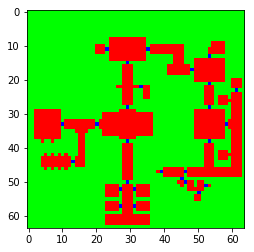

In [11]:
import matplotlib.pyplot as plt

first_map = all_maps[0,].astype('float32')

print(first_map.shape)

plt.imshow(first_map, interpolation='nearest')
plt.show()